<a href="https://colab.research.google.com/github/AjarHDK/Brain_Tumor_Segmentation_U-Net/blob/main/Brats2020_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="text-align: justify; font-weight: bold;">
    <font color='blue'>3D Brain Tumor Segmentation using 3D U-Net Architecture on BraTS 2020 Dataset - Multiclass Segmentation</font>
</h1>

## Overview

This notebook demonstrates the process of performing **multiclass 3D segmentation** on brain MRI images using a **3D U-Net architecture**. The goal is to accurately segment different regions of brain tumors from MRI scans, including the enhancing tumor, the tumor core, and the whole tumor. This task is critical in medical imaging, as it assists doctors in diagnosing and planning treatment for brain tumor patients.

We will be using the  [BraTS 2020 (Brain Tumor Segmentation)](https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation) dataset, which contains MRI scans of patients with gliomas, a type of brain tumor. The MRI scans are provided in multiple modalities and come with corresponding segmentation masks that annotate different tumor regions.

### Key details about the dataset:

- **Image Modality:** The dataset includes four MRI modalities:  
  1. **T1**: T1-weighted, Standard anatomical MRI.  
  2. **T1c**: T1-weighted, contrast-enhanced (Gadolinium) image.  
  3. **T2**: T2-weighted image, MRI sequence that highlights fluid.  
  4. **FLAIR**: Fluid-Attenuated Inversion Recovery, which suppresses fluid signals to better highlight lesions.
  
- **Mask Classes:** The segmentation masks provide labels for different tumor regions:  
   
   - **Label 0: Background** (non-tumor region).
   - **Label 1: Edema** (swelling around the tumor).
   - **Label 2: Non-enhancing tumor** (inactive tumor tissue).
   - **Label 3: Enhancing tumor** (active tumor tissue).
  
- **Data Format:** The images are provided in **3D NIfTI (nii.gz)** format, commonly used medical imaging format to store brain imaging data obtained using MRI and describe different MRI settings, each volume being a 3D array (H x W x D), where H and W are the height and width, and D is the depth (number of slices).

- **Image Size:** The typical size of each 3D MRI scan is **240x240x155 pixels**, though resizing may be applied.

We will walk through the following steps:

1. Loading and preprocessing the 3D MRI images and corresponding segmentation masks.
2. Building a **3D U-Net** model, which is widely used for volumetric medical image segmentation.
3. Training the model on the BraTS 2020 dataset.
4. Evaluating the performance using metrics such as **Dice coefficient** and **Intersection over Union (IoU)**.
5. Visualizing the segmentation results.


In [ ]:
# Importing the necessary module to access Google Drive
from google.colab import drive

# Mounting Google Drive to access files stored there
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Create a directory to store Kaggle API credentials
!mkdir ~/.kaggle

In [ ]:
# Copy the Kaggle API key from Google Drive to the Kaggle directory
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

cp: cannot stat '/content/drive/MyDrive/kaggle.json': No such file or directory


In [ ]:
# Set the permissions of the Kaggle API key file to be readable only by the owner
!chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
# Download the BraTS dataset from Kaggle
!kaggle datasets download -d awsaf49/brats20-dataset-training-validation

Dataset URL: https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation
License(s): CC0-1.0
100% 4.16G/4.16G [00:25<00:00, 221MB/s]
100% 4.16G/4.16G [00:25<00:00, 175MB/s]


In [ ]:
!unzip brats20-dataset-training-validation.zip

<h2><font color='blue'>PART 1: Load Sample Images and Visualize</font></h2>

In this section, we will load sample images from the dataset to gain an initial understanding. The steps include:

1. **Scaling Images:**  
   Each image will be divided by its maximum value to scale the pixel values to the range [0, 1].

2. **Converting Masks:**  
   Masks, initially in float format, will be converted to `uint8` format.

3. **Relabeling Mask Values:**  
   The original mask labels (0, 1, 2, 4) will be modified:  
   - Label 0: Background (not countable)
   - Label 1: Edema  
   - Label 2: Non-enhancing tumor  
   - Label 4: Enhancing tumor (will be changed to 3)

4. **Visualization:**  
   We will visualize some images with their corresponding masks to better understand the data.

**Note :** One of the segmented files in folder 355 has an unusual file name. It needs to be renamed to match the naming convention of the other files.


1854.603271484375
[0 1 2 4]
[0 1 2 3]


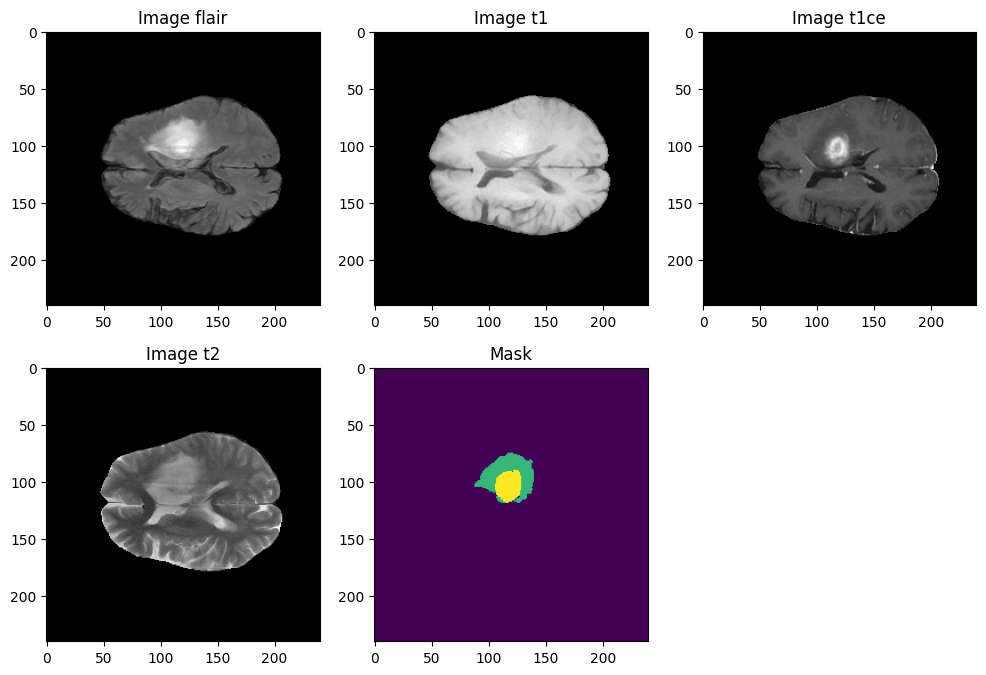

In [ ]:

import numpy as np
import nibabel as nib
import glob
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tifffile import imsave

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()


TRAIN_DATASET_PATH = 'BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
#VALIDATION_DATASET_PATH = 'BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'

test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_flair.nii').get_fdata()
print(test_image_flair.max())
#Scalers are applied to 1D so let us reshape and then reshape back to original shape.
test_image_flair=scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1])).reshape(test_image_flair.shape)


test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t1.nii').get_fdata()
test_image_t1=scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)

test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t1ce.nii').get_fdata()
test_image_t1ce=scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)

test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t2.nii').get_fdata()
test_image_t2=scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)

test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_seg.nii').get_fdata()
test_mask=test_mask.astype(np.uint8)

print(np.unique(test_mask))  #0, 1, 2, 4 (Need to reencode to 0, 1, 2, 3)
test_mask[test_mask==4] = 3  #Reassign mask values 4 to 3
print(np.unique(test_mask))

import random
n_slice=random.randint(0, test_mask.shape[2])

plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.imshow(test_image_flair[:,:,n_slice], cmap='gray')
plt.title('Image flair')
plt.subplot(232)
plt.imshow(test_image_t1[:,:,n_slice], cmap='gray')
plt.title('Image t1')
plt.subplot(233)
plt.imshow(test_image_t1ce[:,:,n_slice], cmap='gray')
plt.title('Image t1ce')
plt.subplot(234)
plt.imshow(test_image_t2[:,:,n_slice], cmap='gray')
plt.title('Image t2')
plt.subplot(235)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()






<h2><font color='blue'>PART 2: Image Preprocessing and Patch Extraction</font></h2>

In this section, we will explore the process of combining images from different modalities into channels and dividing them into patches. The key steps include:

1. **Combining Modalities into Channels:**  
   We will combine the 4 MRI modalities—**T1**, **T2**, **T1CE**, and **FLAIR**—into a single multichannel numpy array.  
   - **FLAIR**, **T1CE**, and **T2** are particularly useful as they contain the most critical information.
   - These modalities will be combined into a single 3-channel image for 3D segmentation.

2. **Cropping for Patch Extraction:**  
   To prepare for extracting 64x64x64 patches later, we will crop the x, y, and z dimensions to sizes divisible by 64. Specifically, we will crop the images to **128x128x128**, ensuring they are ready for patch-based processing.
**Note:** Keras' `ImageDataGenerator` is designed for 2D image data and does not support 3D data out of the box. As a result, we cannot use `ImageDataGenerator` to create batches for 3D images. To handle 3D volumes, we need to implement custom data generators. These custom generators will handle batching, normalization, and preprocessing of 3D images.

(240, 240, 155, 3)
(128, 128, 128, 3)


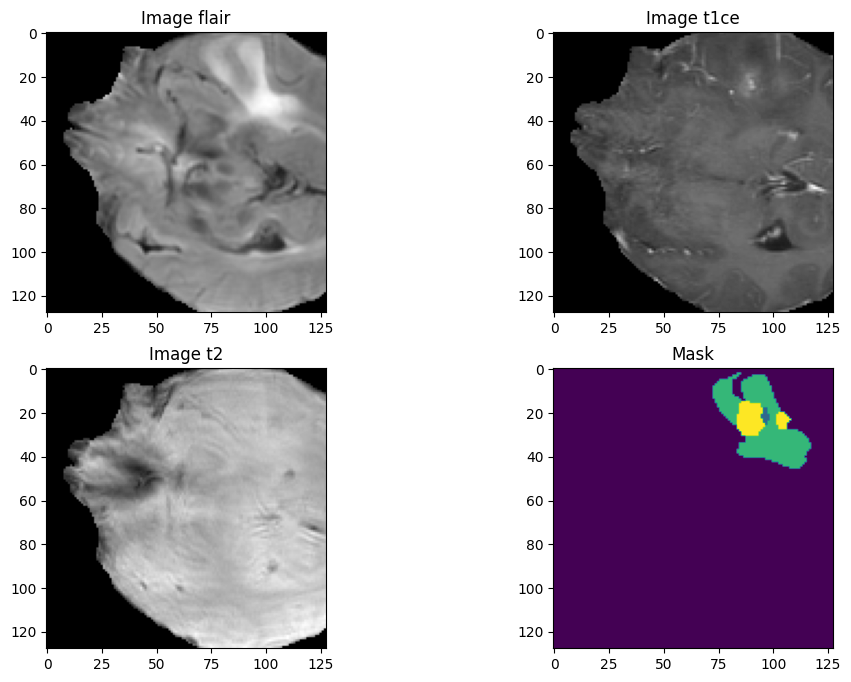

<ipython-input-6-b1bf8052ba2a>:27: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  imsave('BraTS2020_TrainingData/combined255.tif', combined_x)


In [ ]:


combined_x = np.stack([test_image_flair, test_image_t1ce, test_image_t2], axis=3)
print(combined_x.shape)
combined_x=combined_x[56:184, 56:184, 13:141] #Crop to 128x128x128x3
print(combined_x.shape)

#Do the same for mask
test_mask = test_mask[56:184, 56:184, 13:141]

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(combined_x[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(combined_x[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(combined_x[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()


imsave('BraTS2020_TrainingData/combined255.tif', combined_x)
np.save('BraTS2020_TrainingData/combined255.npy', combined_x)
#Verify image is being read properly
#my_img=imread('BraTS2020_TrainingData/combined255.tif')

my_img=np.load('BraTS2020_TrainingData/combined255.npy')

#our mask is 128X128X128 image with 4 classes 0 to 3 lets connvert it to categorical so it is 128X128X128X4(one hot encoding)
test_mask = to_categorical(test_mask, num_classes=4)




We will now apply the same preprocessing steps to all the images by merging the channels, cropping, patchifying, and saving the prepared data. Only images with masks that have more than **1% useful volume** (labels other than 0) will be retained, as training the model on background regions doesn't provide additional useful information.


In [ ]:
#Now let us apply the same as above to all the images...
#Merge channels, crop, patchify, save


#t1_list = sorted(glob.glob('BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t1.nii'))
t2_list = sorted(glob.glob('BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t2.nii'))
t1ce_list = sorted(glob.glob('BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t1ce.nii'))
flair_list = sorted(glob.glob('BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*flair.nii'))
mask_list = sorted(glob.glob('BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*seg.nii'))

#Each volume generates 18 64x64x64x4 sub-volumes.
#Total 369 volumes = 6642 sub volumes

for img in range(len(t2_list)):   #Using t1_list as all lists are of same size
    print("Now preparing image and masks number: ", img)

    temp_image_t2=nib.load(t2_list[img]).get_fdata()
    temp_image_t2=scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)

    temp_image_t1ce=nib.load(t1ce_list[img]).get_fdata()
    temp_image_t1ce=scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)

    temp_image_flair=nib.load(flair_list[img]).get_fdata()
    temp_image_flair=scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)

    temp_mask=nib.load(mask_list[img]).get_fdata()
    temp_mask=temp_mask.astype(np.uint8)
    temp_mask[temp_mask==4] = 3  #Reassign mask values 4 to 3
    #print(np.unique(temp_mask))


    temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2], axis=3)

    #Crop to a size to be divisible by 64 so we can later extract 64x64x64 patches.
    #cropping x, y, and z
    temp_combined_images=temp_combined_images[56:184, 56:184, 13:141]
    temp_mask = temp_mask[56:184, 56:184, 13:141]

    val, counts = np.unique(temp_mask, return_counts=True)

    if (1 - (counts[0]/counts.sum())) > 0.01:  #At least 1% useful volume with labels that are not 0
        print("Save Me")
        temp_mask= to_categorical(temp_mask, num_classes=4)
        np.save('BraTS2020_TrainingData/input_data_3channels/images/image_'+str(img)+'.npy', temp_combined_images)
        np.save('BraTS2020_TrainingData/input_data_3channels/masks/mask_'+str(img)+'.npy', temp_mask)

    else:
        print("I am useless")





<h2><font color='blue'>PART 3: Data Splitting</font></h2>

In this section, we will split the dataset into training, testing, and validation sets. We'll use the `split-folders` library to organize the data into separate folders for each set. This organization is essential for preparing the data for semantic segmentation tasks using custom data generators.

To get started, install the `split-folders` library using the following command:

```python
!pip install split-folders


In [ ]:
pip install split-folders

In [ ]:
################################################################
#Repeat the same from above for validation data folder OR
#Split training data into train and validation

"""
Code for splitting folder into train, test, and val.
Once the new folders are created rename them and arrange in the format below to be used
for semantic segmentation using data generators.

pip install split-folders
"""
import splitfolders  # or import split_folders

input_folder = 'BraTS2020_TrainingData/input_data_3channels/'
output_folder = 'BraTS2020_TrainingData/input_data_128/'
# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.75, .25), group_prefix=None) # default values
########################################

### Custom Data Generator

In this code, we created a custom data generator for loading images and masks from the BraTS2020 dataset. Instead of loading all the data into memory at once, the generator loads small batches of data dynamically during training. **The batch size** is set to **2** to manage memory usage efficiently and ensure that the training process runs smoothly without overloading the system.

Batching allows for faster processing, better optimization, and parallelization during training, making it an essential practice when working with large datasets like medical images

**Batch Size and Volume Considerations**

The batch size of 2 may seem small, but it's important to note that each batch contains 2 volumetric images, each with a resolution of 128x128x128. These 3D images are quite large and require substantial memory to process.

While we could patchify the images into smaller 64x64x64 sub-volumes and increase the batch size, doing so hasn't shown any noticeable difference in performance..

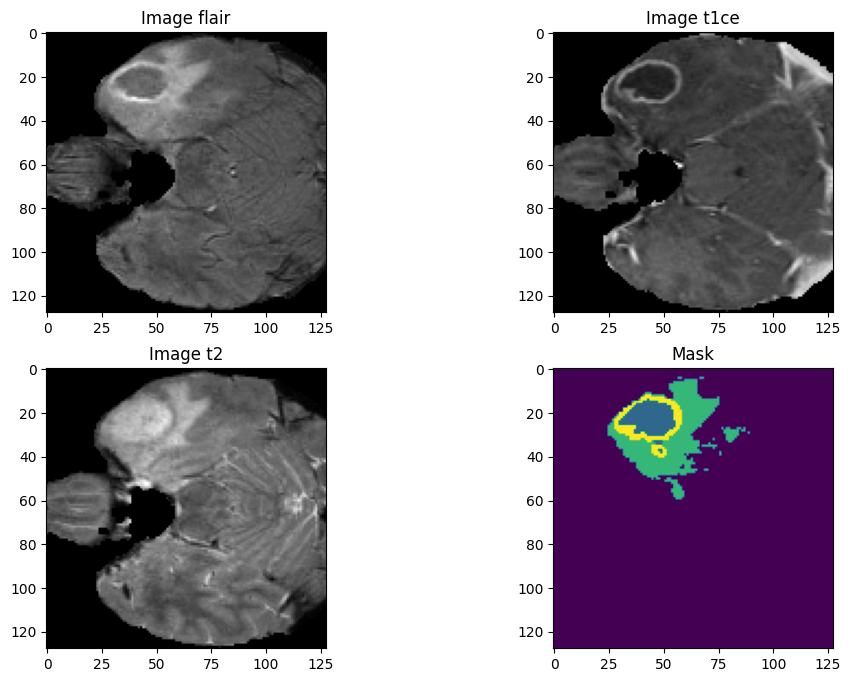

In [ ]:
import os
import numpy as np


def load_img(img_dir, img_list):
    images=[]
    for i, image_name in enumerate(img_list):
        if (image_name.split('.')[1] == 'npy'):

            image = np.load(img_dir+image_name)

            images.append(image)
    images = np.array(images)

    return(images)




def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):

    L = len(img_list)

    #keras needs the generator infinite, so we will use while true
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)

            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])

            yield (X,Y) #a tuple with two numpy arrays with batch_size samples

            batch_start += batch_size
            batch_end += batch_size

############################################

#Test the generator

from matplotlib import pyplot as plt
import random

train_img_dir = "/content/drive/MyDrive/3D_seg/BraTS2020_Data/input_data_128/train/images/"
train_mask_dir = "/content/drive/MyDrive/3D_seg/BraTS2020_Data/input_data_128/train/masks/"
train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list,
                                train_mask_dir, train_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
img, msk = train_img_datagen.__next__()


img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

<h2><font color='blue'>PART 4: Building the 3D U-Net Model</font></h2>


In [ ]:
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.metrics import MeanIoU

kernel_initializer =  'he_uniform' #Try others if you want


################################################################
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)

    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)

    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)

    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)

    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)

    #Expansive path
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)

    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)

    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)

    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)

    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    #compile model outside of this function to make it flexible.
    model.summary()

    return model

#Test if everything is working ok.
model = simple_unet_model(128, 128, 128, 3, 4)
print(model.input_shape)
print(model.output_shape)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 128,  │              0 │ -                      │
│                           │ 3)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d (Conv3D)           │ (None, 128, 128, 128,  │          1,312 │ input_layer[0][0]      │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128, 128, 128,  │              0 │ conv3d[0][0]           │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_1 (Conv3D)         │ (None, 128, 128, 128,  │          6,928 │ dropout[0][0]          │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d             │ (None, 64, 64, 64, 16) │              0 │ conv3d_1[0][0]         │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_2 (Conv3D)         │ (None, 64, 64, 64, 32) │         13,856 │ max_pooling3d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64, 64, 64, 32) │              0 │ conv3d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_3 (Conv3D)         │ (None, 64, 64, 64, 32) │         27,680 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_1           │ (None, 32, 32, 32, 32) │              0 │ conv3d_3[0][0]         │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_4 (Conv3D)         │ (None, 32, 32, 32, 64) │         55,360 │ max_pooling3d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 32, 32, 32, 64) │              0 │ conv3d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_5 (Conv3D)         │ (None, 32, 32, 32, 64) │        110,656 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_2           │ (None, 16, 16, 16, 64) │              0 │ conv3d_5[0][0]         │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_6 (Conv3D)         │ (None, 16, 16, 16,     │        221,312 │ max_pooling3d_2[0][0]  │
│                           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 16, 16, 16,     │              0 │ conv3d_6[0][0]         │
│                           │ 128)                   │                │                        │
├──────────────────────

 Total params: 5,645,828 (21.54 MB)

 Trainable params: 5,645,828 (21.54 MB)

 Non-trainable params: 0 (0.00 B)

(None, 128, 128, 128, 3)
(None, 128, 128, 128, 4)




*   **Images** are expected to be **128x128x128x3** npy data (3 corresponds to the 3 channels for test_image_flair, test_image_t1ce, test_image_t2)

*   **Masks** are expected to be **128x128x128x4** npy data (4 corresponds to the 4 classes / labels)

**Note :** we can change input image sizes to customize for our computing resources

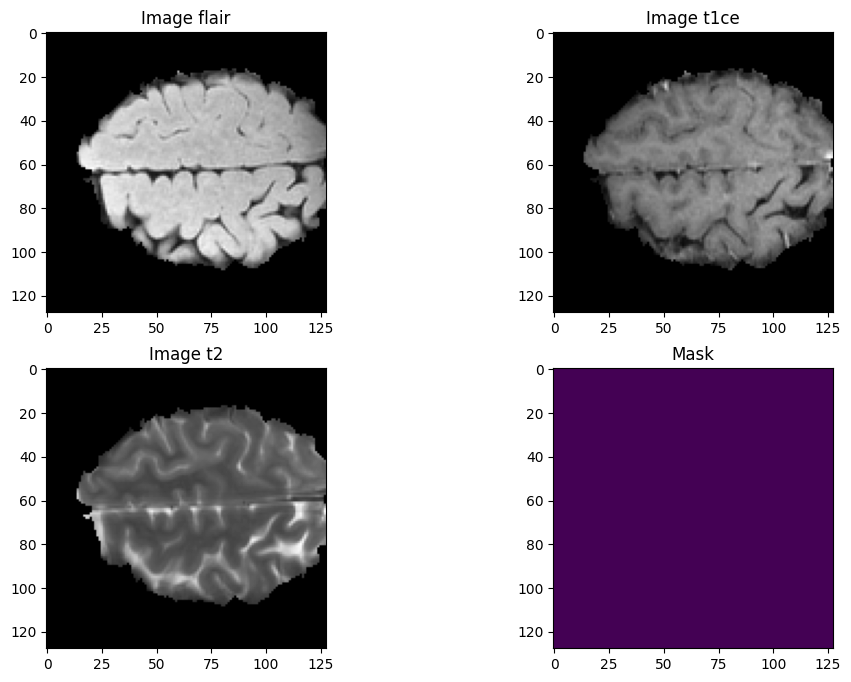

In [ ]:
import os
import numpy as np

#import tensorflow as tf
import keras
from matplotlib import pyplot as plt
import glob
import random

train_img_dir = "/content/drive/MyDrive/3D_seg/BraTS2020_Data/input_data_128/train/images/"
train_mask_dir = "/content/drive/MyDrive/3D_seg/BraTS2020_Data/input_data_128/train/masks/"

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

num_images = len(os.listdir(train_img_dir))

img_num = random.randint(0,num_images-1)
test_img = np.load(train_img_dir+img_list[img_num])
test_mask = np.load(train_mask_dir+msk_list[img_num])
test_mask = np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [ ]:
import os
import numpy as np
import nibabel as nib
import glob
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
import tensorflow.keras as keras
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

Define the image generators for training and validation

**Note :** Due to resource limitations and the computational cost, we are only using 150 MRI volumes for training and 20 for validation. However, if resources allow, you can train on the full dataset for potentially better results.

258
86


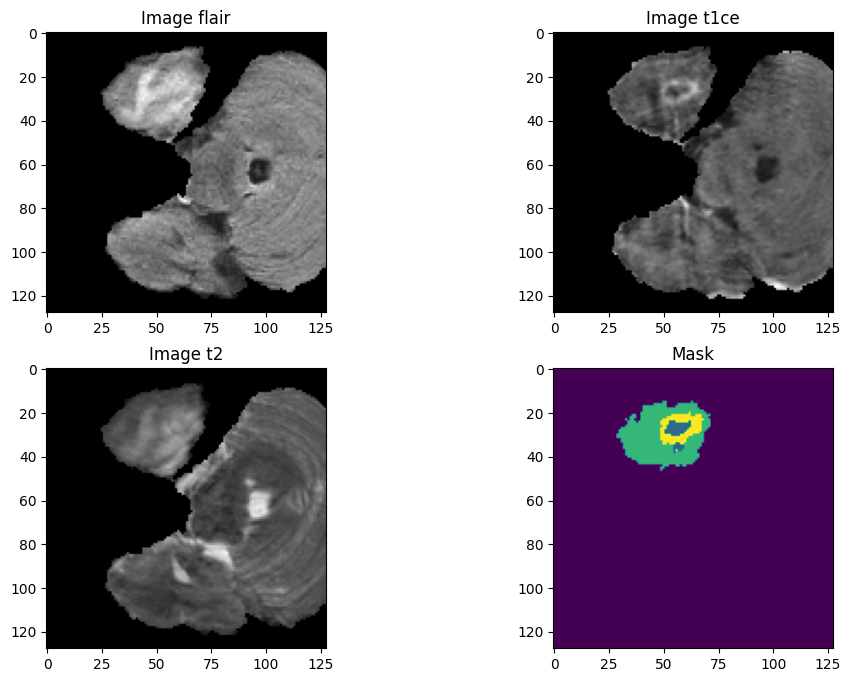

In [ ]:

train_img_dir = "/content/drive/MyDrive/3D_seg/BraTS2020_Data/input_data_128/train/images/"
train_mask_dir = "/content/drive/MyDrive/3D_seg/BraTS2020_Data/input_data_128/train/masks/"

val_img_dir = "/content/drive/MyDrive/3D_seg/BraTS2020_Data/input_data_128/val/images/"
val_mask_dir = "/content/drive/MyDrive/3D_seg/BraTS2020_Data/input_data_128/val/masks/"

train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)
print(len(train_img_list))
train_img_list=train_img_list[:50]
train_mask_list=train_mask_list[:50]

val_img_list=os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)
print(len(val_img_list))

val_img_list=val_img_list[:10]
val_mask_list=val_mask_list[:10]

batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list,
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list,
                                val_mask_dir, val_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
img, msk = train_img_datagen.__next__()

img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
#argmax here is to convert the test_mask from categorical array 128x128x128x4 to an array 128x128x128
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()



<h2><font color='blue'>PART 5: Training the model</font></h2>

In [ ]:
pip install segmentation_models_3D

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.8/69.8 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 59.8 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 128, 128, 128,  │              0 │ -                      │
│ (InputLayer)              │ 3)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_38 (Conv3D)        │ (None, 128, 128, 128,  │          1,312 │ input_layer_2[0][0]    │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_18 (Dropout)      │ (None, 128, 128, 128,  │              0 │ conv3d_38[0][0]        │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_39 (Conv3D)        │ (None, 128, 128, 128,  │          6,928 │ dropout_18[0][0]       │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_8           │ (None, 64, 64, 64, 16) │              0 │ conv3d_39[0][0]        │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_40 (Conv3D)        │ (None, 64, 64, 64, 32) │         13,856 │ max_pooling3d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_19 (Dropout)      │ (None, 64, 64, 64, 32) │              0 │ conv3d_40[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_41 (Conv3D)        │ (None, 64, 64, 64, 32) │         27,680 │ dropout_19[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_9           │ (None, 32, 32, 32, 32) │              0 │ conv3d_41[0][0]        │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_42 (Conv3D)        │ (None, 32, 32, 32, 64) │         55,360 │ max_pooling3d_9[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_20 (Dropout)      │ (None, 32, 32, 32, 64) │              0 │ conv3d_42[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_43 (Conv3D)        │ (None, 32, 32, 32, 64) │        110,656 │ dropout_20[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_10          │ (None, 16, 16, 16, 64) │              0 │ conv3d_43[0][0]        │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_44 (Conv3D)        │ (None, 16, 16, 16,     │        221,312 │ max_pooling3d_10[0][0] │
│                           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_21 (Dropout)      │ (None, 16, 16, 16,     │              0 │ conv3d_44[0][0]        │
│                           │ 128)                   │                │                        │
├──────────────────────

 Total params: 5,645,828 (21.54 MB)

 Trainable params: 5,645,828 (21.54 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 128, 128, 128,  │              0 │ -                      │
│ (InputLayer)              │ 3)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_38 (Conv3D)        │ (None, 128, 128, 128,  │          1,312 │ input_layer_2[0][0]    │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_18 (Dropout)      │ (None, 128, 128, 128,  │              0 │ conv3d_38[0][0]        │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_39 (Conv3D)        │ (None, 128, 128, 128,  │          6,928 │ dropout_18[0][0]       │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_8           │ (None, 64, 64, 64, 16) │              0 │ conv3d_39[0][0]        │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_40 (Conv3D)        │ (None, 64, 64, 64, 32) │         13,856 │ max_pooling3d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_19 (Dropout)      │ (None, 64, 64, 64, 32) │              0 │ conv3d_40[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_41 (Conv3D)        │ (None, 64, 64, 64, 32) │         27,680 │ dropout_19[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_9           │ (None, 32, 32, 32, 32) │              0 │ conv3d_41[0][0]        │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_42 (Conv3D)        │ (None, 32, 32, 32, 64) │         55,360 │ max_pooling3d_9[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_20 (Dropout)      │ (None, 32, 32, 32, 64) │              0 │ conv3d_42[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_43 (Conv3D)        │ (None, 32, 32, 32, 64) │        110,656 │ dropout_20[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_10          │ (None, 16, 16, 16, 64) │              0 │ conv3d_43[0][0]        │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_44 (Conv3D)        │ (None, 16, 16, 16,     │        221,312 │ max_pooling3d_10[0][0] │
│                           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_21 (Dropout)      │ (None, 16, 16, 16,     │              0 │ conv3d_44[0][0]        │
│                           │ 128)                   │                │                        │
├──────────────────────

 Total params: 5,645,828 (21.54 MB)

 Trainable params: 5,645,828 (21.54 MB)

 Non-trainable params: 0 (0.00 B)

None
(None, 128, 128, 128, 3)
(None, 128, 128, 128, 4)
Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 244s 10s/step - accuracy: 0.6110 - loss: 1.0074 - val_accuracy: 0.9562 - val_loss: 0.9719
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.9594 - loss: 0.9602 - val_accuracy: 0.9588 - val_loss: 0.9569
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.9624 - loss: 0.9428 - val_accuracy: 0.9590 - val_loss: 0.9574
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.9633 - loss: 0.9419 - val_accuracy: 0.9590 - val_loss: 0.9414
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.9634 - loss: 0.9344 - val_accuracy: 0.9590 - val_loss: 0.9396
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.9634 - loss: 0.9287 - val_accuracy: 0.9590 - val_loss: 0.9359
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.9635 - loss: 0.9234 - val_accuracy: 0.9597 - val_loss: 0.9384
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - a

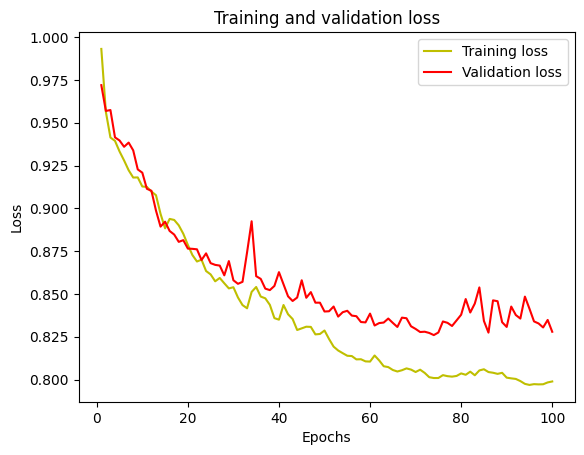

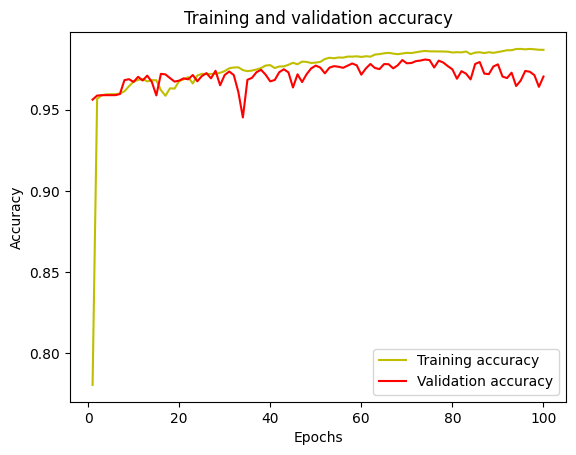

In [ ]:
#Define loss, metrics and optimizer to be used for training
wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25
import segmentation_models_3D as sm
dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3]))
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)
#metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]

metrics = ['accuracy']

LR = 0.0001
optim = keras.optimizers.Adam(LR)


#Fit the model
steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size



model = simple_unet_model(IMG_HEIGHT=128,
                          IMG_WIDTH=128,
                          IMG_DEPTH=128,
                          IMG_CHANNELS=3,
                          num_classes=4)

model.compile(optimizer = optim, loss=total_loss, metrics=metrics)
print(model.summary())

print(model.input_shape)
print(model.output_shape)

history=model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=100,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )
#saving the model
model.save('/content/drive/MyDrive/brats_3d_100epochs.hdf5')


#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



<h2><font color='blue'>PART 6: Evaluating the model</font></h2>


### Loading the model





In [ ]:
from keras.models import load_model

model = load_model('/content/drive/MyDrive/brats_3d_100epochs.hdf55', compile=False)

In this section, we will compute the Intersection over Union (IoU) metric to evaluate the performance of our segmentation model. The IoU is a crucial metric used to measure the accuracy of our model's predictions by comparing the overlap between the predicted segmentation and the ground truth mask. Below, we use the `MeanIoU` class from Keras to calculate the IoU for a batch of validation images and their corresponding masks. The results give us insight into how well the model performs in segmenting the relevant areas of the images.


### IoU (Intersection over Union) score


In [ ]:

from keras.metrics import MeanIoU

batch_size=8 #Check IoU for a batch of images
test_img_datagen = imageLoader(val_img_dir, val_img_list,
                                val_mask_dir, val_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
test_image_batch, test_mask_batch = test_img_datagen.__next__()

test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
test_pred_batch = model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)

n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())




1/1 ━━━━━━━━━━━━━━━━━━━━ 32s 32s/step
Mean IoU = 0.5816825


### *Interpretation*
The Mean IoU (Intersection over Union) score achieved by the model is 0.6397. This result reflects a moderate performance, which is expected given the relatively small training set of 150 MRI volumes. While the segmentation accuracy improves as more data is used for training, as indicated by this IoU score, the limited dataset constrains the model’s ability to generalize effectively. Additionally, the resource limitations, such as GPU timeouts, make it difficult to further scale the training, since processing larger datasets significantly increases training time, with each epoch taking approximately 900 seconds. This emphasizes the trade-off between improving model performance and the computational resources required.


### Predictions
Here, we  make predictions on individual test images using our trained 3D segmentation model. We load specific image and mask pairs from the validation dataset, generate predictions, and visualize the results. we can visually verify the performance of our model slice by slice. This process helps us assess the accuracy of our model in segmenting medical images, such as MRI scans.

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


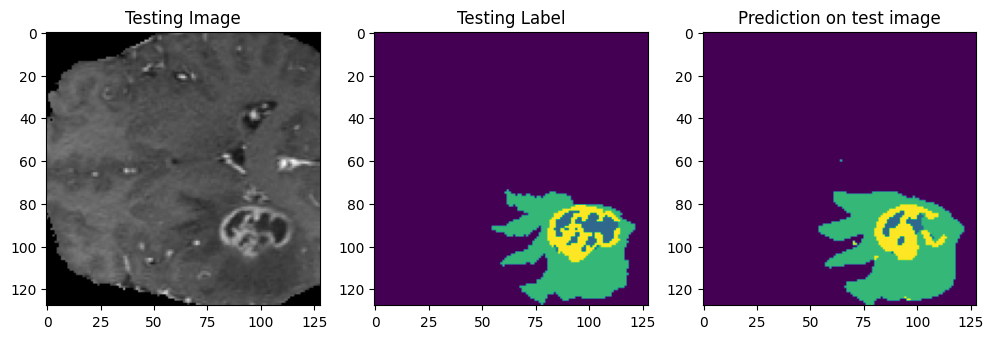

In [ ]:
img_num = 82

test_img = np.load("/content/drive/MyDrive/3D_seg/BraTS2020_Data/input_data_128/val/images/image_"+str(img_num)+".npy")

test_mask = np.load("/content/drive/MyDrive/3D_seg/BraTS2020_Data/input_data_128/val/masks/mask_"+str(img_num)+".npy")
test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = model.predict(test_img_input)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]



#Plot individual slices from test predictions for verification
from matplotlib import pyplot as plt
import random

#n_slice=random.randint(0, test_prediction_argmax.shape[2])
n_slice = 55
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:, n_slice])
plt.show()


### *Interpretation*
The model's predictions on the test images show promising results, as evidenced by the visual comparisons between the ground truth labels and the predicted segmentations. The generated segmentation maps capture the essential features and structures present in the MRI scans, particularly in the regions of interest. However, there are still some discrepancies between the predicted masks and the actual labels, which can be attributed to the limited training data. The model tends to perform better in regions with more prominent features but struggles in areas with less distinct boundaries. This underscores the potential for further improvement with an increase in training data, which could enhance the model's generalization capabilities and overall segmentation accuracy.
